In [1]:
import pandas as pd
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, validation_curve, GridSearchCV
from sklearn.feature_selection import SelectKBest, SelectFromModel, mutual_info_classif, f_classif
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, balanced_accuracy_score, confusion_matrix, precision_recall_curve, matthews_corrcoef, make_scorer, auc

from sklearn.cluster import FeatureAgglomeration, MiniBatchKMeans
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, SVMSMOTE, BorderlineSMOTE, KMeansSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
seed = 123
path = "/kaggle/input/p53-mutants/K9.data"

In [3]:
# load features as X
X = pd.read_csv(
    path,
    na_values="?", 
    usecols=range(5408),
    dtype='float32', 
    header=None
)

# load class labels as Y
Y = pd.read_csv(
    path, 
    na_values="?", 
    usecols=[5408], 
    header=None, 
    names=["class"]
)

# Exploratory analysis

### Missing values

137 cases have missing values for all of the features, while 124 cases have missing values for at least 89% of the features. All of these 261 cases are from the majority class ('inactive') and will be deleted.

In [4]:
anyNull = X[X.isnull().any(axis=1)].index

# drop missing values (137 all NAs + 124 cases ~90% NAs)
X = X.drop(anyNull)
Y = Y.drop(anyNull)

print(X.shape)
print(Y.shape)

(31159, 5408)
(31159, 1)


inactive class:  31008
active class:    151
class ratio:     0.48%


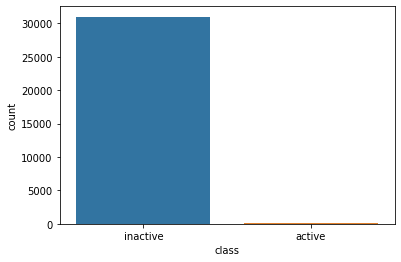

In [5]:
# convert Y to 1D array of 0/1
Y_int = np.array((Y == 'active').astype("int")).ravel()

# plot class distribution
sns.countplot(Y.loc[:, "class"]);

print(f"inactive class:  {(Y_int == 0).sum()}")
print(f"active class:    {Y_int.sum()}")
print(f"class ratio:     {Y_int.mean():.2%}")

## Visual exploration of entire dataset

We used different unsupervised linear (PCA) and non-linear (t-SNE) 2- or 3-dimensional representations to visualize the data and class separability in the dimension-reduced space. This was done both on the entire feature set, as well on the 2D electrostatic and surface characteristics (features 0:4827) and the 3D distances (features 4827:5408) separately, given the observation that their univariate distributions are clearly different. To improve clarity, the majority class was downsampled prior to plotting.

In addition to these unsupervised dimension-reduction techniques, LDA was used to evaluate class separability in a single-dimensional mapping based on the class labels.

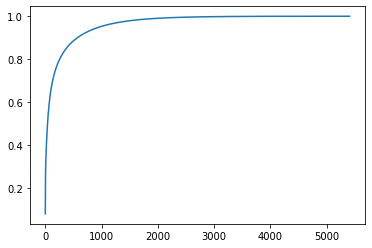

In [6]:
# Step I: PCA on entire feature space
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)
plt.plot(pca.explained_variance_ratio_.cumsum());

In [7]:
# visual exploration of first few principal components
n_comp = 7
pca = PCA(n_comp)
pca.fit(X_scaled)
print(f"First {n_comp} PC's explain {sum(pca.explained_variance_ratio_):.2%} of total variance.")
X_pc = pca.transform(X_scaled)

First 7 PC's explain 29.62% of total variance.


In [8]:
def ds_majority_class(x, y=Y_int, n=500):
    """
    Downsamples inactive class up to a dataset of n samples
    """
    inactive_idx = np.where(y == 0)[0]
    active_idx = np.where(y == 1)[0]
    sample_idx = np.concatenate((np.random.choice(inactive_idx, n - y.sum()), active_idx))
    
    if isinstance(x, pd.DataFrame):
        return x.iloc[sample_idx, :], y[sample_idx]
    
    return x[sample_idx, :], y[sample_idx]

First 2 PC's explain 14.91% of total variance.


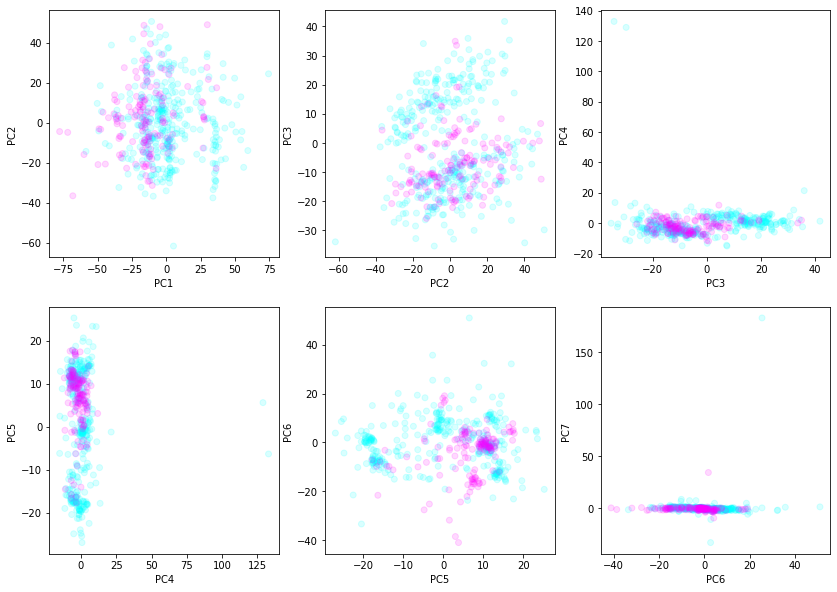

In [9]:
# downsample majority class for plotting
X_pc_sample, Y_int_sample = ds_majority_class(x=X_pc)

print(f"First 2 PC's explain {sum(pca.explained_variance_ratio_[:2]):.2%} of total variance.")

plt.figure(num=None, figsize=(14, 10))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.scatter(X_pc_sample[:, i - 1], X_pc_sample[:, i], c=Y_int_sample, alpha=0.15, cmap="cool")
    plt.xlabel("PC" + str(i))
    plt.ylabel("PC" + str(i + 1))

First 3 PC's explain 20.19% of total variance.


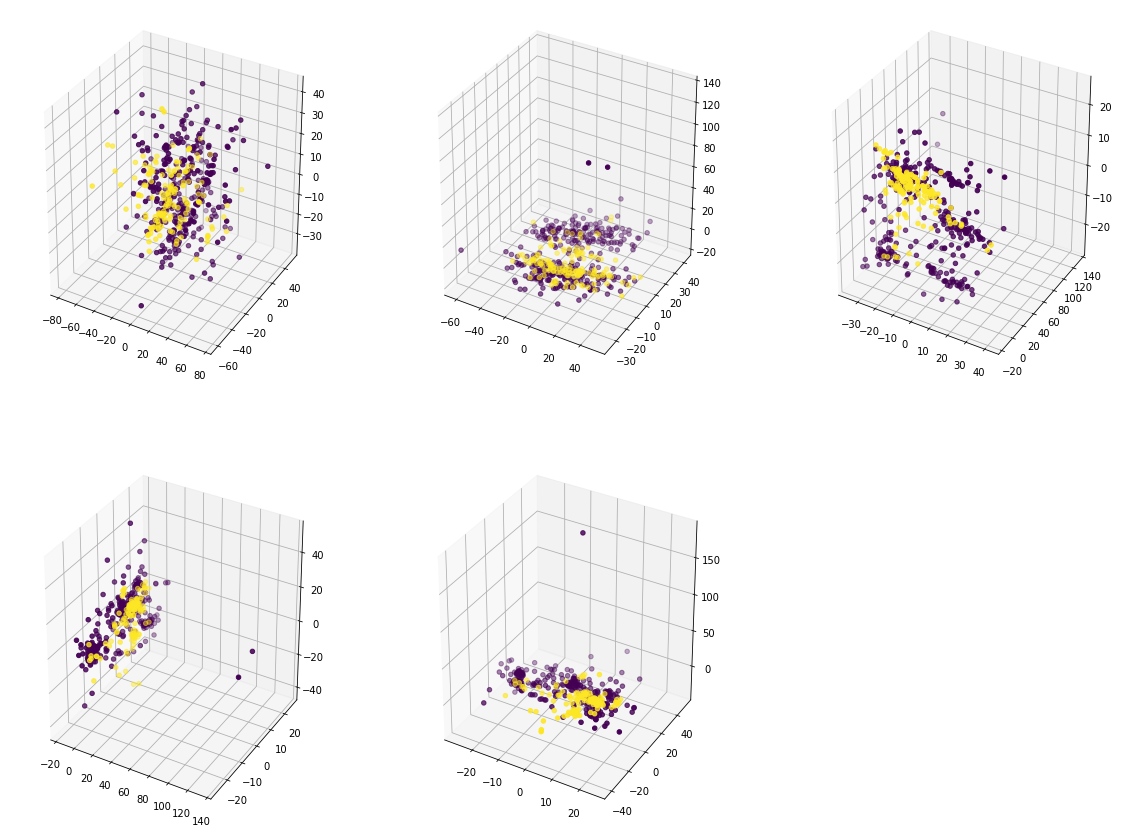

In [10]:
# plot per 3 PCs
from mpl_toolkits.mplot3d import Axes3D 

print(f"First 3 PC's explain {sum(pca.explained_variance_ratio_[:3]):.2%} of total variance.")

fig = plt.figure(figsize=(20, 15))

for i in range(5):
    ax = fig.add_subplot(231 + i, projection='3d')
    ax.scatter(X_pc_sample[:, i],  X_pc_sample[:, i+1], X_pc_sample[:, i+2], c=Y_int_sample)

In [11]:
# export 
allfeatures_3PC = X_pc_sample[:, :3]
allfeatures_3PC = np.concatenate([allfeatures_3PC, Y_int_sample.reshape(-1, 1)], axis=1)

out = pd.DataFrame(data=allfeatures_3PC, columns=["PC1", "PC2", "PC3", "class"])
out.to_csv("PCA_allfeatures.csv")

In [12]:
# Step II: PCA on 2D features and 3D features seperately
X_2d, X_3d = X.loc[:, :4827], X.loc[:, 4827:]
X_2d_scaled = ss.fit_transform(X_2d)
X_3d_scaled = ss.fit_transform(X_3d)

plt.plot(PCA().fit(X_2d).explained_variance_ratio_.cumsum());
plt.plot(PCA().fit(X_3d).explained_variance_ratio_.cumsum(), c="orange");

In [13]:
# first 7 principal components of 2D features 
pca = PCA(n_components=7)
X_2d_pc = pca.fit_transform(X_2d_scaled)
print(f"First 2 PC's explain {sum(pca.explained_variance_ratio_[:2]):.2%} of total variance.")
print(f"First 7 PC's explain {sum(pca.explained_variance_ratio_):.2%} of total variance.")

# downsample majority class and plot
X_2d_pc_sample, Y_int_sample = ds_majority_class(x=X_2d_pc)

plt.figure(num=None, figsize=(14, 10))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.scatter(X_2d_pc_sample[:, i - 1], X_2d_pc_sample[:, i], c=Y_int_sample, alpha=0.15, cmap="cool")
    plt.xlabel("PC" + str(i))
    plt.ylabel("PC" + str(i + 1))

First 2 PC's explain 14.23% of total variance.
First 7 PC's explain 28.26% of total variance.


In [14]:
# plot per 3 PCs
from mpl_toolkits.mplot3d import Axes3D 

print(f"First 3 PC's explain {sum(pca.explained_variance_ratio_[:3]):.2%} of total variance.")

fig = plt.figure(figsize=(20, 15))

for i in range(5):
    ax = fig.add_subplot(231 + i, projection='3d')
    ax.scatter(X_2d_pc_sample[:, i],  X_2d_pc_sample[:, i+1], X_2d_pc_sample[:, i+2], c=Y_int_sample)

First 3 PC's explain 18.59% of total variance.


In [15]:
# export 
out = X_2d_pc_sample[:, :3]
out = np.concatenate([out, Y_int_sample.reshape(-1, 1)], axis=1)

out = pd.DataFrame(data=out, columns=["PC1", "PC2", "PC3", "class"])
out.to_csv("PCA_2Dfeatures.csv")

First 2 PC's explain 37.43% of total variance.
First 7 PC's explain 50.56% of total variance.


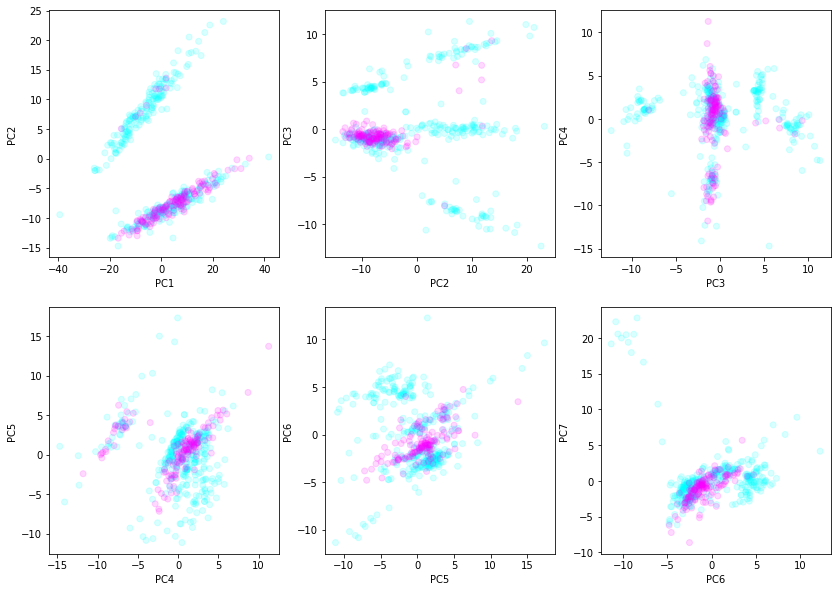

In [16]:
# Same for 3D distance features (features 4827:5408)
X_3d_pc = pca.fit_transform(X_3d_scaled)
print(f"First 2 PC's explain {sum(pca.explained_variance_ratio_[:2]):.2%} of total variance.")
print(f"First 7 PC's explain {sum(pca.explained_variance_ratio_):.2%} of total variance.")

# downsample majority class and plot
X_3d_pc_sample, Y_int_sample = ds_majority_class(x=X_3d_pc)

plt.figure(num=None, figsize=(14, 10))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.scatter(X_3d_pc_sample[:, i - 1], X_3d_pc_sample[:, i], c=Y_int_sample, alpha=0.15, cmap="cool")
    plt.xlabel("PC" + str(i))
    plt.ylabel("PC" + str(i + 1))

First 3 PC's explain 41.11% of total variance.


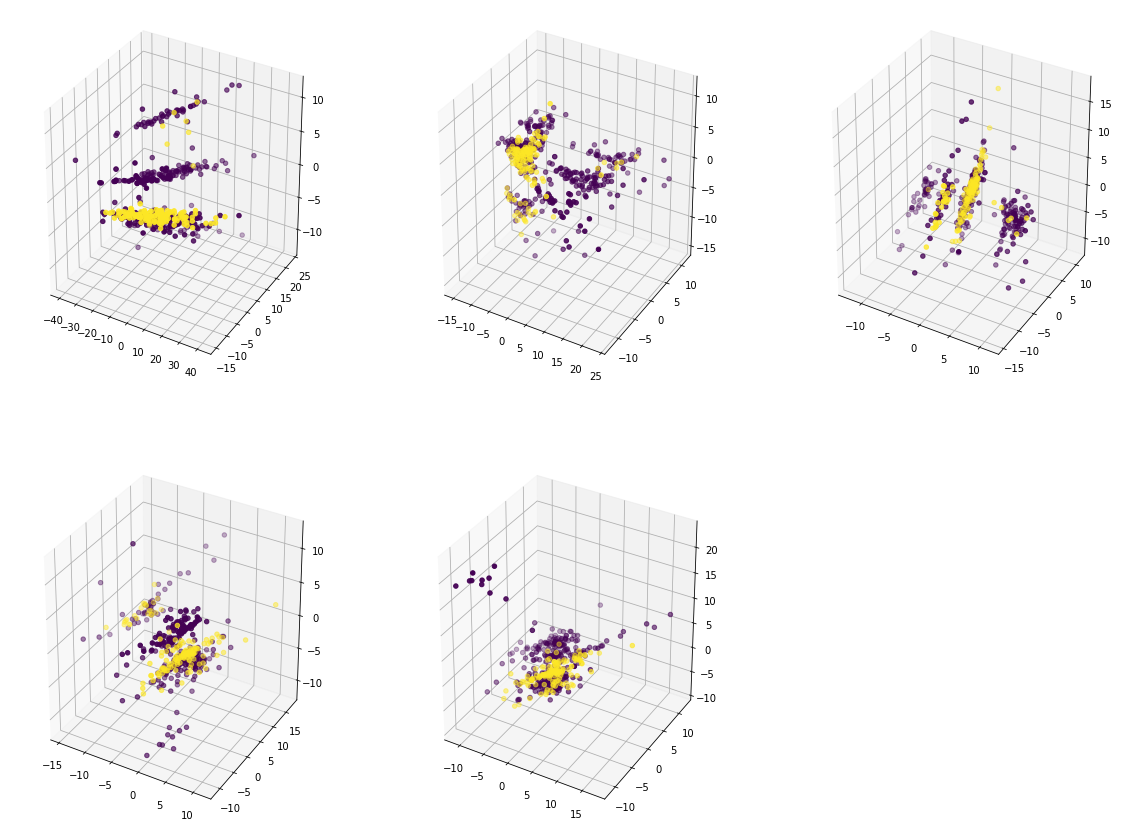

In [17]:
# plot per 3 PCs
from mpl_toolkits.mplot3d import Axes3D 

print(f"First 3 PC's explain {sum(pca.explained_variance_ratio_[:3]):.2%} of total variance.")

fig = plt.figure(figsize=(20, 15))

for i in range(5):
    ax = fig.add_subplot(231 + i, projection='3d')
    ax.scatter(X_3d_pc_sample[:, i],  X_3d_pc_sample[:, i+1], X_3d_pc_sample[:, i+2], c=Y_int_sample)

In [18]:
# export 
out = X_3d_pc_sample[:, :3]
out = np.concatenate([out, Y_int_sample.reshape(-1, 1)], axis=1)

out = pd.DataFrame(data=out, columns=["PC1", "PC2", "PC3", "class"])
out.to_csv("PCA_3Dfeatures.csv")

In [19]:
# tSNE
from sklearn.manifold import TSNE

In [20]:
# reduce dim (https://lvdmaaten.github.io/tsne/)
x_ = StandardScaler().fit_transform(X)
x_ = PCA(n_components=50).fit_transform(x_)

In [21]:
print(x_.shape)
print(Y_int.mean())

(31159, 50)
0.004846111877788119


In [22]:
# downsample majority class to speed up iterations
from imblearn.under_sampling import RandomUnderSampler

DS = RandomUnderSampler(sampling_strategy=0.1)
x, y = DS.fit_resample(x_, Y_int)

print(x.shape)
print(y.mean())

(1661, 50)
0.09090909090909091


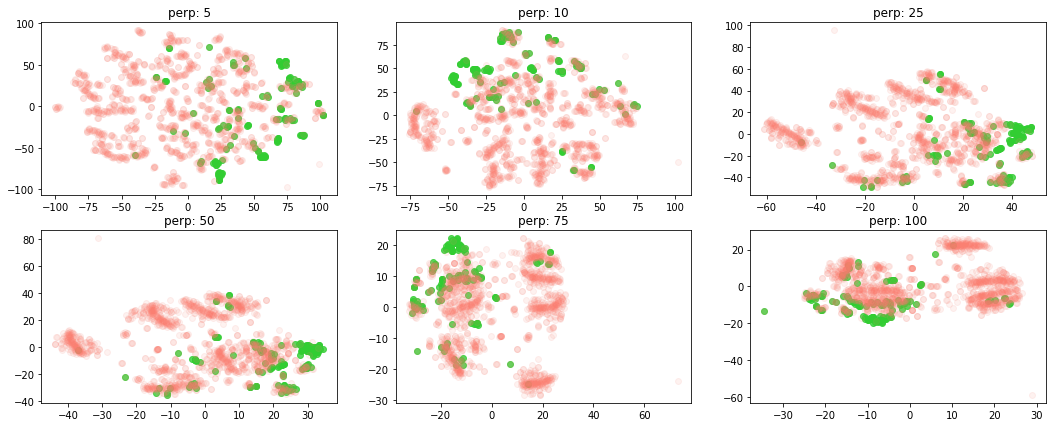

In [23]:
# test different perplexities: 2D mapping
perplexities = [5, 10, 25, 50, 75, 100]
active = (y == 1)
inactive = (y == 0)

fig = plt.figure(figsize=(18, 7))

for i, perplexity in enumerate(perplexities):

    tsne = TSNE(n_components=2, init='random', random_state=123, perplexity=perplexity)
    x__ = tsne.fit_transform(x)
    
    ax = fig.add_subplot(231 + i)
    ax.set_title(f"perp: {perplexity}")
    ax.scatter(x__[active, 0], x__[active, 1], c="limegreen", alpha=0.8)
    ax.scatter(x__[inactive, 0], x__[inactive, 1], c="salmon", alpha=0.1)

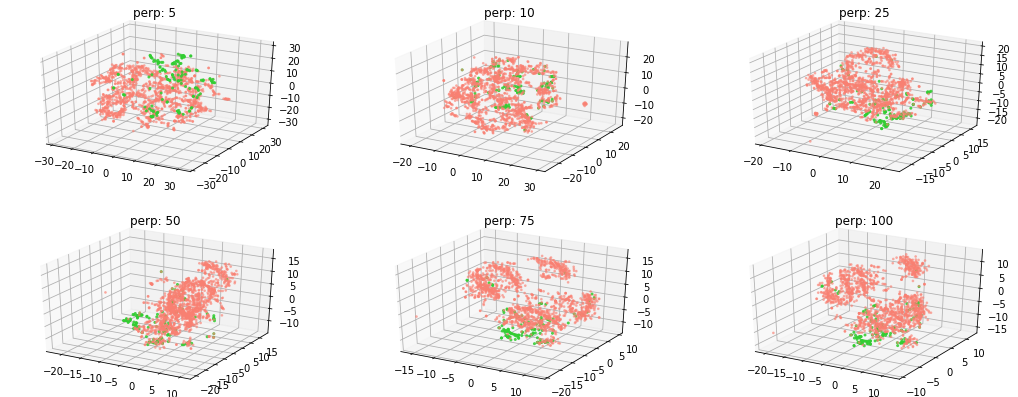

In [24]:
# test different perplexities: 3D mapping
perplexities = [5, 10, 25, 50, 75, 100]
active = (y == 1)
inactive = (y == 0)

fig = plt.figure(figsize=(18, 7))

for i, perplexity in enumerate(perplexities):

    tsne = TSNE(n_components=3, init='random', random_state=123, perplexity=perplexity)
    x__ = tsne.fit_transform(x)
    
    ax = fig.add_subplot(231 + i, projection='3d')
    ax.set_title(f"perp: {perplexity}")
    
    ax.scatter(x__[active, 0], x__[active, 1], x__[active, 2], c="limegreen", s=4, alpha=0.8)
    ax.scatter(x__[inactive, 0], x__[inactive, 1], x__[inactive, 2], c="salmon", s=3, alpha=0.5)

In [25]:
# export 
out = X_3d_pc_sample[:, :3]
out = np.concatenate([out, Y_int_sample.reshape(-1, 1)], axis=1)

out = pd.DataFrame(data=out, columns=["PC1", "PC2", "PC3", "class"])
out.to_csv("PCA_3Dfeatures.csv")

In [26]:
# repeat for 3D distance features
x_ = PCA(n_components=50).fit_transform(X_3d_scaled)

# downsample majority class to speed up iterations
from imblearn.under_sampling import RandomUnderSampler

DS = RandomUnderSampler(sampling_strategy=0.1)
x, y = DS.fit_resample(x_, Y_int)

print(x.shape)
print(y.mean())

(1661, 50)
0.09090909090909091


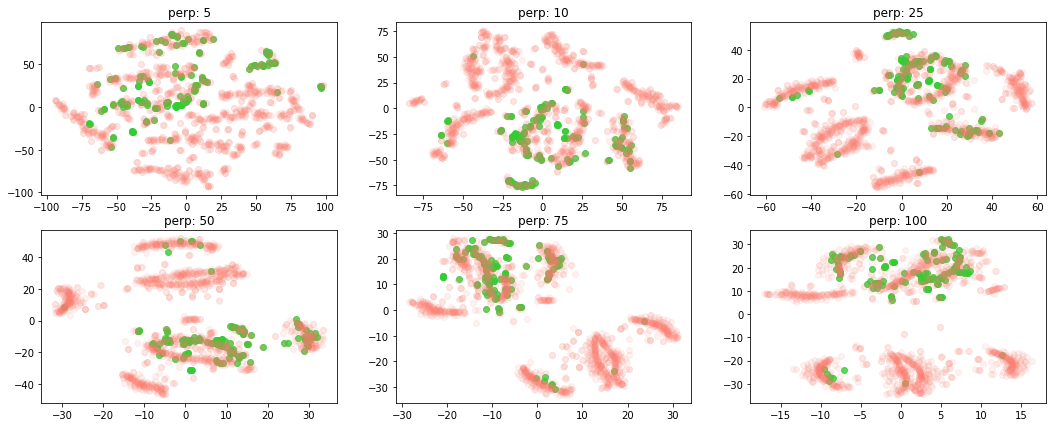

In [27]:
# 2D tSNE of 3D distance features only
perplexities = [5, 10, 25, 50, 75, 100]
active = (y == 1)
inactive = (y == 0)

fig = plt.figure(figsize=(18, 7))

for i, perplexity in enumerate(perplexities):

    tsne = TSNE(n_components=2, init='random', random_state=123, perplexity=perplexity)
    x__ = tsne.fit_transform(x)
    
    ax = fig.add_subplot(231 + i)
    ax.set_title(f"perp: {perplexity}")
    ax.scatter(x__[active, 0], x__[active, 1], c="limegreen", alpha=0.8)
    ax.scatter(x__[inactive, 0], x__[inactive, 1], c="salmon", alpha=0.1)

In [28]:
# 3D tSNE of 3D distance features only
fig = plt.figure(figsize=(18, 7))

for i, perplexity in enumerate(perplexities):

    tsne = TSNE(n_components=3, init='random', random_state=123, perplexity=perplexity)
    x__ = tsne.fit_transform(x)
    
    ax = fig.add_subplot(231 + i, projection='3d')
    ax.set_title(f"perp: {perplexity}")
    
    ax.scatter(x__[active, 0], x__[active, 1], x__[active, 2], c="limegreen", s=4, alpha=0.8)
    ax.scatter(x__[inactive, 0], x__[inactive, 1], x__[inactive, 2], c="salmon", s=3, alpha=0.5)

In [29]:
# supervised dim-reduction: sparseLDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto", n_components=1)
X_lda = lda.fit(X, Y_int).transform(X)

In [30]:
sns.boxplot(x=Y_int, y=X_lda[:,0]);

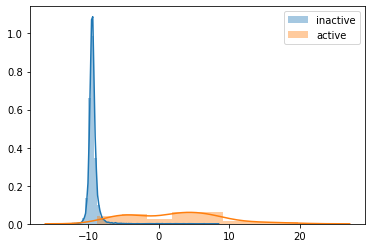

In [31]:
sns.distplot(X_lda[Y_int == 0], label="inactive");
sns.distplot(X_lda[Y_int == 1], label="active");
plt.legend(loc='best', shadow=False);

Conclusion: no clear separation between classes in the dimension-reduced space (~PCA). This is not very surprising, due to i) the high nr of features (each PC explains only a very small fraction of the total variance in the original feature space) and ii) the fact that some outliers seem to have a lot of influence in determining the directions of larges variance in the original feature space (for PCA). In addition, the choice of the linear subspace onto which the data is projected is not based on the class separability as such.

The first 7 PCs of the 3D elektrostatic features explain around 50% of total variance (of the 3D features) and there appears to be a slighly more defined clustering of the classes in the dimension-reduced space as compared to the 2D features. Similar conclusions for tSNE mappings. Supervised dimension reduction (in terms of class labels) with LDA consisting of orthogonally projecting all instances onto a vector that maximizes the between- vs within variance wrt to the classes results in a relatively clear class separability.

## Bivariate correlations between features

Linear correlation between features was checked visually on a small subset of the features. This is done by manually computing the variance covariance matrix of the standardized data matrix. The feature pairs with the highest Pearson correlation are checked visually using scatterplots. During prediction and model training, strategies to reduce the feature dimensionality that condition on the pairwise correlation between features will be considered.

In [32]:
# test if manual removal of correlated features improves results
X_scaled = StandardScaler().fit_transform(X)

# use matrix multiplication on scaled features for reasons of speed
# at the cost of numerical stability
X_corr = np.matmul(X_scaled.T, X_scaled)   
X_corr /= X_corr.shape[0]

# collect pairwise correlation measures
x = pd.DataFrame(X_corr).abs()
X_corr_ = (
    x.where(np.triu(np.ones(x.shape), k=1).astype(np.bool)) # remove diagonal
    .stack()
    .sort_values(ascending=False)
)

In [33]:
# top n highly correlated feature pairs
n = 1500
top = X_corr_[:n]

# unique features to remove given top n highly correlated feature pairs
f_rem = set([x[0] for x in top.index])
print(len(f_rem))
f_keep = set(X.columns) - f_rem
print(len(f_keep))

574
4834


In [34]:
# given the class inbalance, check visually for a low nr of feature pairs to evaluate if the strong pairwise
# correlations aren't determined by the majority class only, i.e. indicating that removal might result in
# loss of potentially important information
N = 10

plt.figure(figsize=(20, N))

for i, (a, b) in enumerate(top.index[0: N].tolist()):
    plt.subplot(N // 5, 5, i + 1)
    x, y = X.iloc[:, a], X.iloc[:, b]
    r = x.corr(y)
    sns.scatterplot(x=x, y=y, alpha=0.5, hue=Y_int, size=Y_int, sizes=(50, 5));
    plt.title("rho = " + str(round(r, 3)))

In [35]:
# repeat for tail of topN feature pairs
N = 20

plt.figure(figsize=(20, N))

for i, (a, b) in enumerate(top.index[-N:].tolist()):
    plt.subplot(N // 5, 5, i + 1)
    x, y = X.iloc[:, a], X.iloc[:, b]
    r = x.corr(y)
    sns.scatterplot(x=x, y=y, alpha=0.5, hue=Y_int, size=Y_int, sizes=(50, 5));
    plt.title("rho = " + str(round(r, 3)))

In [36]:
# remove ~500 features based on pairwise correlations
X_red = X.loc[:, f_keep]
print(X_red.shape)

(31159, 4834)


In [37]:
DS = RandomUnderSampler(sampling_strategy=0.01)
X_, Y_ = DS.fit_resample(X, Y)
print(X.shape)
print(X_.shape)
print(Y_.mean())

(31159, 5408)
(15251, 5408)
Series([], dtype: float64)


In [38]:
# output top 9 for visualization in R
tmp = pd.DataFrame(
    index=np.arange(X_.shape[0]), 
    columns=["pair", "x1", "x2", "class"]
)

out = pd.DataFrame(
    columns=["pair", "x1", "x2", "class"]
)

for i, (a, b) in enumerate(top[:9].index.tolist()):

    tmp["x1"], tmp["x2"] = X_.iloc[:, a], X_.iloc[:, b]
    tmp["class"] = Y_
    tmp["pair"] = f"{a} vs. {b} (rho = {(X.iloc[:, a].corr(X.iloc[:, b])):.3f})"

    out = pd.concat([out, tmp])

In [39]:
out.to_csv("pairwise_corr.csv")

In [40]:
# plot some correlation matrices around diagonal
plt.figure(figsize=(40, 40))

for i in range(100, 3100, 100):
    plt.subplot(6, 5, i // 100)
    sns.heatmap(X_corr[i - 100: i, i - 100: i]);

In [41]:
# check some 3D features
plt.figure(figsize=(40, 5))
j = 0
for i in range(4827, 5327, 100):
    j += 1
    plt.subplot(1, 5, j)
    sns.heatmap(X_corr[i - 100: i, i - 100: i]);

In [42]:
# repeat PCA and tSNE with ~500 features removed
X_red = X.loc[:, f_keep]

In [43]:
X_red_scaled = StandardScaler().fit_transform(X_red)

pca = PCA(n_components=7)
X_red_pca = pca.fit_transform(X_red_scaled)

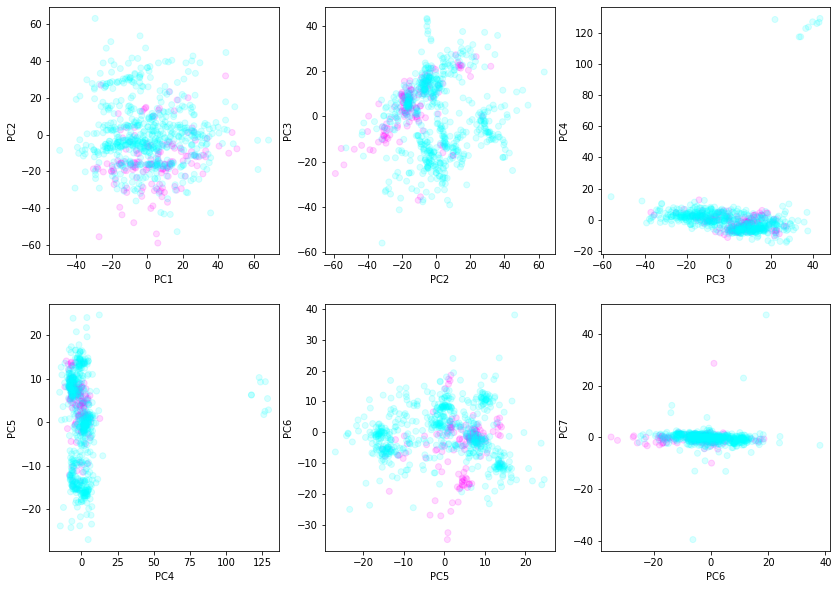

In [44]:
#downsample and plot
X_pc_sample, Y_sample = RandomUnderSampler(sampling_strategy=0.25).fit_resample(X_red_pca, Y)
Y_sample = (Y_sample["class"] == "active").astype("int")
plt.figure(num=None, figsize=(14, 10))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.scatter(X_pc_sample[:, i - 1], X_pc_sample[:, i], c=Y_sample, alpha=0.15, cmap="cool")
    plt.xlabel("PC" + str(i))
    plt.ylabel("PC" + str(i + 1))

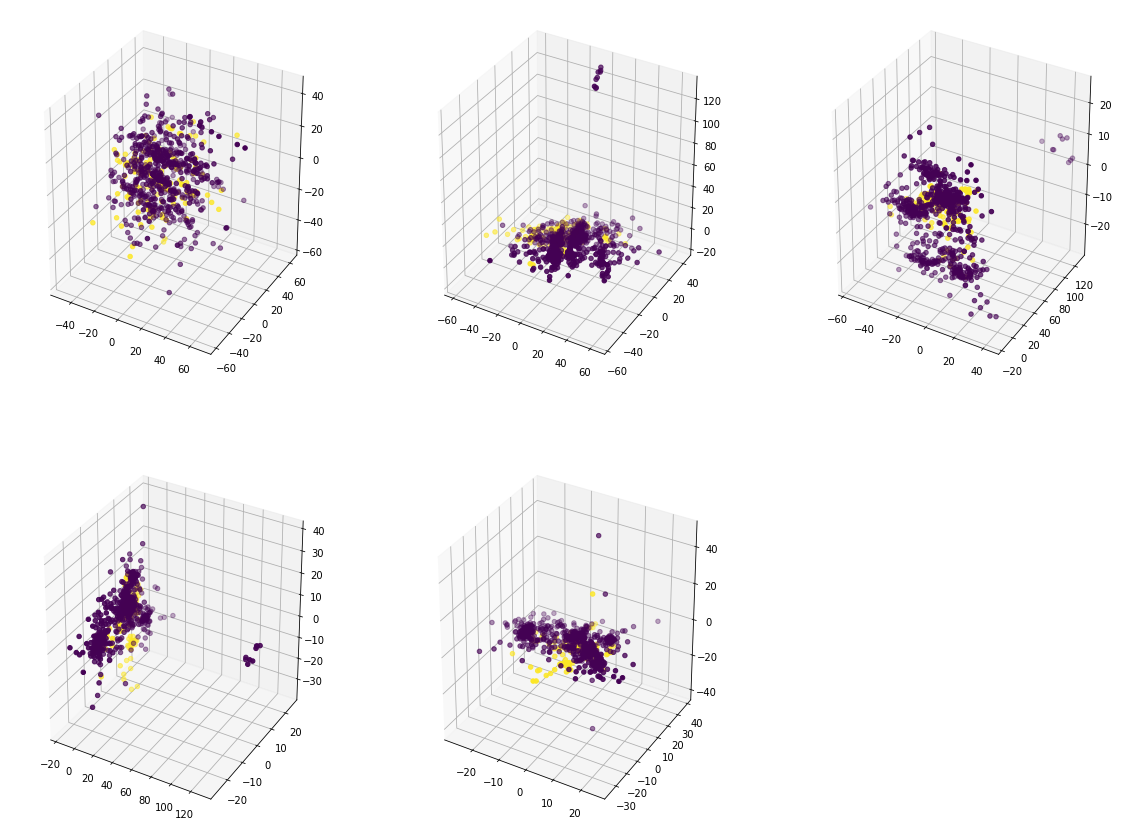

In [45]:
# plot per 3 PCs
fig = plt.figure(figsize=(20, 15))

for i in range(5):
    ax = fig.add_subplot(231 + i, projection='3d')
    ax.scatter(X_pc_sample[:, i],  X_pc_sample[:, i+1], X_pc_sample[:, i+2], c=Y_sample)

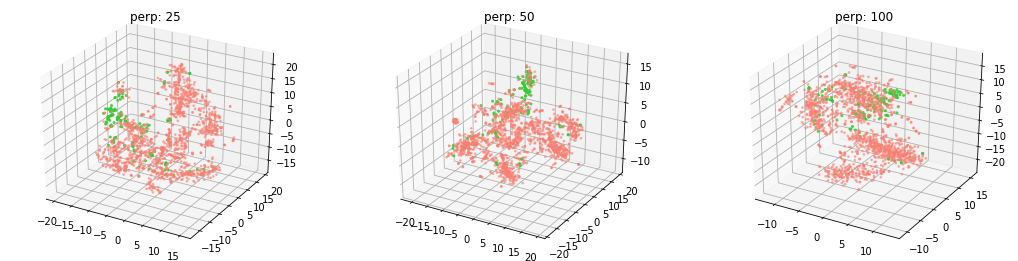

In [46]:
# repeat procedure with tSNE

# all features (reduced)
x_ = PCA(n_components=50).fit_transform(X_red_scaled)
DS = RandomUnderSampler(sampling_strategy=0.1)
x, y = DS.fit_resample(x_, Y_int)

# test different perplexities
perplexities = [25, 50, 100]
active = (y == 1)
inactive = (y == 0)

# 3D tSNE of 3D distance features only
fig = plt.figure(figsize=(18, 10))

for i, perplexity in enumerate(perplexities):

    tsne = TSNE(n_components=3, init='random', random_state=123, perplexity=perplexity)
    x__ = tsne.fit_transform(x)
    
    ax = fig.add_subplot(231 + i, projection='3d')
    ax.set_title(f"perp: {perplexity}")
    
    ax.scatter(x__[active, 0], x__[active, 1], x__[active, 2], c="limegreen", s=4, alpha=0.8)
    ax.scatter(x__[inactive, 0], x__[inactive, 1], x__[inactive, 2], c="salmon", s=3, alpha=0.5)

# Univariate class separability

The class separability or information overlap between classes for every feature individually was investigated.

In [47]:
from sklearn.feature_selection import f_classif, mutual_info_classif

F_stat = f_classif(X, Y_int)
MIC = mutual_info_classif(X, Y_int)

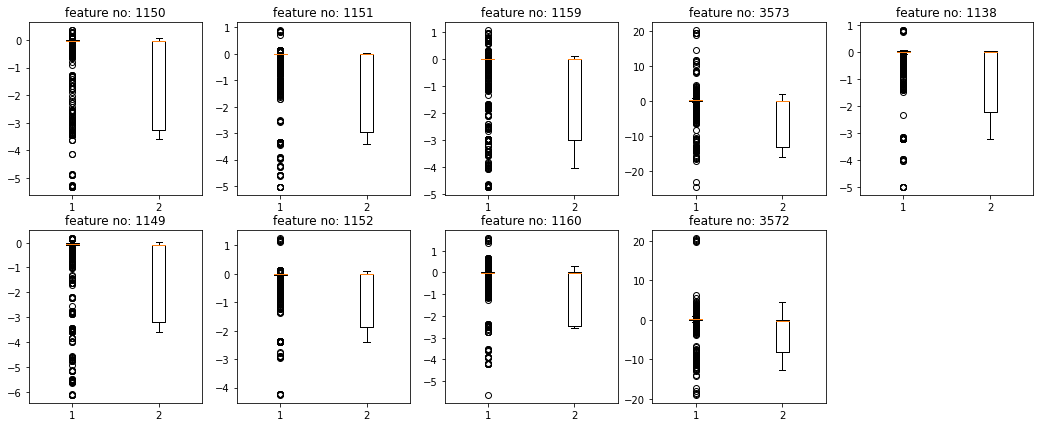

In [48]:
# plot highest F-scores
N = 9
F_stat_topN = F_stat[0].argsort()[-N:][::-1]

fig = plt.figure(figsize=(18, 7))

for i, x in enumerate(F_stat_topN):
    ax = fig.add_subplot(251 + i)
    ax.set_title(f"feature no: {x}")
    
    ax.boxplot([X.iloc[Y_int == 0, x], X.iloc[Y_int==1, x]])

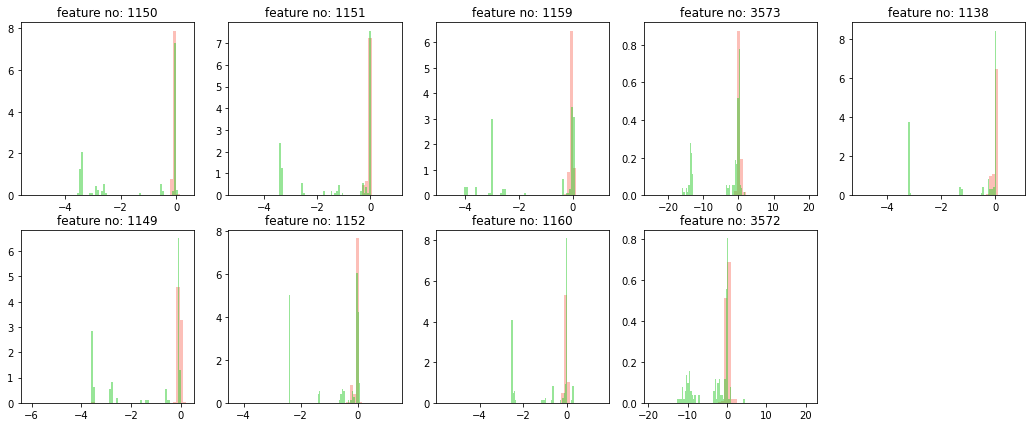

In [49]:
fig = plt.figure(figsize=(18, 7))

for i, x in enumerate(F_stat_topN):
    ax = fig.add_subplot(251 + i)
    ax.set_title(f"feature no: {x}")
    # plot density per class
    ax.hist(X.iloc[Y_int == 0, x], density=True, alpha=0.5, bins=50, color="salmon");
    ax.hist(X.iloc[Y_int == 1, x], density=True, alpha=0.5, bins=50, color="limegreen");

In [50]:
# plot highest MIC scores
N = 9
MIC_topN = MIC.argsort()[-N:][::-1]

fig = plt.figure(figsize=(18, 7))

for i, x in enumerate(MIC_topN):
    ax = fig.add_subplot(251 + i)
    ax.set_title(f"feature no: {x}")
    
    ax.boxplot([X.iloc[Y_int == 0, x], X.iloc[Y_int==1, x]])

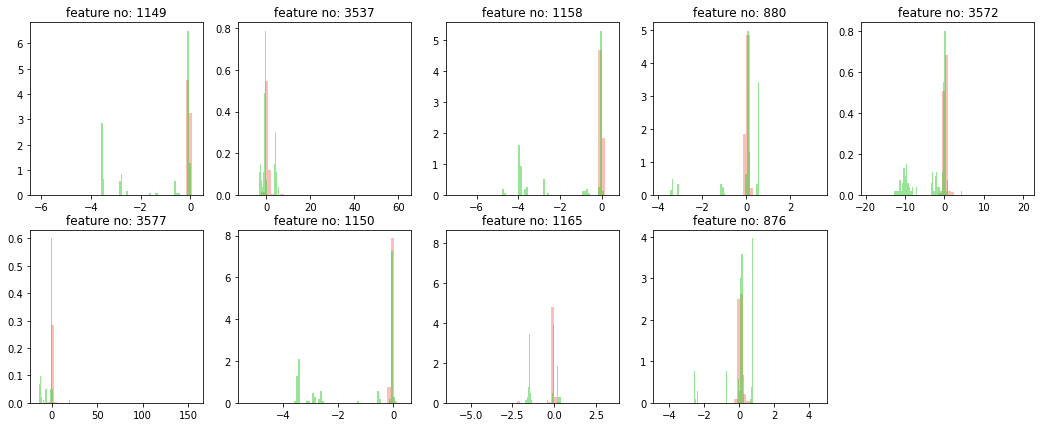

In [51]:
# plot highest MIC scores
N = 9
MIC_topN = MIC.argsort()[-N:][::-1]

fig = plt.figure(figsize=(18, 7))

for i, x in enumerate(MIC_topN):
    ax = fig.add_subplot(251 + i)
    ax.set_title(f"feature no: {x}")
    # plot density per class
    ax.hist(X.iloc[Y_int == 0, x], density=True, alpha=0.5, bins=50, color="salmon");
    ax.hist(X.iloc[Y_int == 1, x], density=True, alpha=0.5, bins=50, color="limegreen");

In [52]:
N = 9
MIC_topN = MIC.argsort()[-N:][::-1]
MIC_topN

array([1149, 3537, 1158,  880, 3572, 3577, 1150, 1165,  876])

Both parametric and non-parametric approaches to quantify univariate "class separability" or information overlap per feature underline the challenges related to the class inbalance: the variability within every class rather than differences in the centrality measures of the distributions dictate the scores.